### Popularity-Based Recommender
Generating recommendations using different types of popularity measures


In [1]:
import pandas as pd

book_test_df = pd.read_csv('data/Books.test.csv.gz', compression='gzip', sep=',', header=0)
book_val_df = pd.read_csv('data/Books.valid.csv.gz', compression='gzip', sep=',', header=0)
book_train_df = pd.read_csv('data/Books.train.csv.gz', compression='gzip', sep=',', header=0)

book_train_df.head()

,user_id,parent_asin,rating,timestamp,history
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1446304000,5.0,1441260345000,NaN
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1564770672,5.0,1441260365000,1446304000
2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1442450703,5.0,1523093714024,1446304000 1564770672
3,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1780671067,1.0,1611623223325,1446304000 1564770672 1442450703
4,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1645671127,3.0,1612044209266,1446304000 1564770672 1442450703 1780671067


In [2]:
#summary of data
print("Training set: ", book_train_df.shape)
print("Val Set: ", book_val_df.shape)
print("Test Set: ", book_test_df.shape)
print(book_test_df.head())
print()
print(book_val_df.head())
print("Unique Users: ", book_train_df['user_id'].nunique())
print("size of train set", len(book_train_df))
print("size of val set", len(book_val_df))
print("size of test set", len(book_test_df))


Training set:  (7935557, 5)
Val Set:  (776370, 5)
Test Set:  (776370, 5)
                        user_id parent_asin  rating      timestamp  \
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  0593235657     5.0  1640629604904   
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  0803736800     4.0  1454676557000   
2  AGXFEGMNVCSTSYYA5UWXDV7AFSXA  1542046599     5.0  1605649719611   
3  AFWHJ6O3PV4JC7PVOJH6CPULO2KQ  0679450815     5.0  1638987703546   
4  AHXBL3QDWZGJYH7A5CMPFNUPMF7Q  1250866448     5.0  1669414969335   

                                             history  
0  1446304000 1564770672 1442450703 1780671067 16...  
1  0811849783 0803729952 0735336296 1508558884 08...  
2        1578052009 1477493395 1594747350 1594749310  
3  B00INIQVJA 1496407903 1974633225 B07KD27RHM 16...  
4  0920668372 1589255208 2764322836 2764330898 00...  

                        user_id parent_asin  rating      timestamp  \
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1782490671     5.0  1640383495102   
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  08

In [4]:
book_train_df.drop(['timestamp', 'history'], axis=1, inplace=True)

In [5]:
#example of history column
print(type(book_val_df.iloc[0]['history']))
x = book_val_df.iloc[0]['history']
x = x.split(" ")
for product in x:
    print(product)

<class 'str'>
1446304000
1564770672
1442450703
1780671067
1645671127
1784881953
1640210148
0823098079


## Approaches to getting list of popular items
Rationale: There are multiple approaches to getting the most popular items. The approach we take to getting the most popular could influence the performance. 


Approach 1: Naive Popularity Score <br>
- simplest approach
- this approach gets the most popular items in the training set only by counting the number of times each book was purchased and sorting by most purchased <br>

Approach 2: Average Rating Score <br>
- this approach gets the average rating for each item, and sorts them by highest average rating to find the most popular
- may not work because ratings are all too high, similar averages for items <br>

Approach 3: Global Popularity Score <br>
- this approach gets the most popular items across the training, validation and test sets by counting the number of times each book was purchased and sorting by most purchased <br>
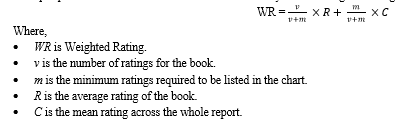

#### Approach 1 : Naive Popularity Score
Uses a regular count to find the most popular items. Does not take into account the actual ratings of each item. Only counts the number of ratings per item and assumes that if an item was purchased, it was popular. 

In [6]:
# Count purchases per item
purchase_counts = (
    book_train_df.groupby("parent_asin")
              .size()
              .reset_index(name="purchase_count")
)

print(purchase_counts)

# Sort by most purchased
popular_items = purchase_counts.sort_values(
    "purchase_count",
    ascending=False
)
print(popular_items)

# Convert to list (most purchased first)
pop_list = popular_items["parent_asin"].head(5000).tolist()
print(pop_list)

       parent_asin  purchase_count
0       0000013714               5
1       000100039X              11
2       0001061240               5
3       0001361155               5
4       0001473727              17
...            ...             ...
494138  B0C8GGPD1H              56
494139  B0C8GHMWG7             369
494140  B0C8GJYMNH             602
494141  B0CCK4H78Y              12
494142  B0CFWT48FK               2

[494143 rows x 2 columns]
       parent_asin  purchase_count
445331  B00L9B7IKE           10683
430470  B006LSZECO            7430
444391  B00JO8PEN2            6871
440008  B00DPM7TIG            6132
439148  B00CNQ7HAU            4914
...            ...             ...
494086  B0C2NPXMMQ               1
494082  B0C1SYJBLG               1
494081  B0C1PBVHKJ               1
494067  B0C1JFQXKB               1
494061  B0C1JB5GBP               1

[494143 rows x 2 columns]
['B00L9B7IKE', 'B006LSZECO', 'B00JO8PEN2', 'B00DPM7TIG', 'B00CNQ7HAU', 'B016ZNRC0Q', 'B00C2WDD5I', 'B00YTX

In [7]:
#For each user in val and test sets, get their product recommendations while also filtering out their previously purchased books in the 'history' field
def get_popularity_recs(df, k):
    user_recs = {}
    for _, row in df.iterrows():
        user_id = row["user_id"]
        #gets users previously purchased books
        history = set(row['history'].split(" "))

        # for each item in the popularity list, add it to recommendations if its not in the users history
        filtered = [item for item in pop_list if item not in history]

        #grab top k
        user_recs[user_id] = filtered[:k]
    return user_recs

simple_val_user_recs_10 = get_popularity_recs(book_val_df, k=10)
simple_test_user_recs_10 = get_popularity_recs(book_test_df, k=10)
simple_val_user_recs_50 = get_popularity_recs(book_val_df, k=50)
simple_test_user_recs_50 = get_popularity_recs(book_test_df, k=50)

In [8]:
# checks if the actual book purchased next in val and test sets is included in recs for each user 
# compares number of hits to the total number of books purchased to get the hit rate with k items being recommended
def hit_rate_at_k(df,recs):
    hits = 0
    for _, row in df.iterrows():
        user_id = row["user_id"]
        item = row["parent_asin"]

        if user_id in recs and item in recs[user_id]:
            #print("got a hit")
            hits += 1

    return (hits / len(df))*100

simple_val_hr10 = hit_rate_at_k(book_val_df, simple_val_user_recs_10)
simple_test_hr10 = hit_rate_at_k(book_test_df, simple_test_user_recs_10)
simple_val_hr50 = hit_rate_at_k(book_val_df, simple_val_user_recs_50)
simple_test_hr50 = hit_rate_at_k(book_test_df, simple_test_user_recs_50)
print(f"Validation Hit Rate@10: {simple_val_hr10}")
print(f"Test Hit Rate@10: {simple_test_hr10}")
print(f"Validation Hit Rate@50: {simple_val_hr50}")
print(f"Test Hit Rate@50: {simple_test_hr50}")

Validation Hit Rate@10: 0.6455684789468938
Test Hit Rate@10: 0.47696330357947886
Validation Hit Rate@50: 2.0039414196839136
Test Hit Rate@50: 1.645607120316344


#### Approach 2: Average Rating Score
This approach gets the most popular items based on average ratings of each book. 

In [9]:
# Count purchases per item
purchase_counts = (
    book_train_df.groupby("parent_asin")
              .size()
              .reset_index(name="purchase_count")
)
print("Purchased Counts: \n", purchase_counts)

# Sort by most purchased
popular_items = purchase_counts.sort_values(
    "purchase_count",
    ascending=False
)
print("Sorted Purchased Counts: \n", popular_items)

# Take 5000 most popular (by raw count) books
popular_items = popular_items["parent_asin"].head(5000)

# Get average rating of each books
avg_ratings = book_train_df.groupby("parent_asin")["rating"].mean().reset_index(name="avg_rating")

# For top 5000 most popular books, include their average rating
popularity_df = pd.merge(popular_items, avg_ratings, on="parent_asin", how="left")

# sort top 5000 by avg rating
popularity_df.sort_values("avg_rating", ascending=False, inplace=True)

print(len(popularity_df))
print(popularity_df.head())
pop_list = popularity_df["parent_asin"].tolist()
print(pop_list)


Purchased Counts: 
        parent_asin  purchase_count
0       0000013714               5
1       000100039X              11
2       0001061240               5
3       0001361155               5
4       0001473727              17
...            ...             ...
494138  B0C8GGPD1H              56
494139  B0C8GHMWG7             369
494140  B0C8GJYMNH             602
494141  B0CCK4H78Y              12
494142  B0CFWT48FK               2

[494143 rows x 2 columns]
Sorted Purchased Counts: 
        parent_asin  purchase_count
445331  B00L9B7IKE           10683
430470  B006LSZECO            7430
444391  B00JO8PEN2            6871
440008  B00DPM7TIG            6132
439148  B00CNQ7HAU            4914
...            ...             ...
494086  B0C2NPXMMQ               1
494082  B0C1SYJBLG               1
494081  B0C1PBVHKJ               1
494067  B0C1JFQXKB               1
494061  B0C1JB5GBP               1

[494143 rows x 2 columns]
5000
     parent_asin  avg_rating
3606  B09C3YW934    4.975

In [10]:
#For each user in val and test sets, get their product recommendations while also filtering out their previously purchased books in the 'history' field
def get_popularity_recs(df, k):
    user_recs = {}
    for _, row in df.iterrows():
        user_id = row["user_id"]
        #gets users previously purchased books
        history = set(row['history'].split(" "))

        # for each item in the popularity list, add it to recommendations if its not in the users history
        filtered = [item for item in pop_list if item not in history]

        #grab top k
        user_recs[user_id] = filtered[:k]
    return user_recs

val_user_recs_10 = get_popularity_recs(book_val_df, k=10)
test_user_recs_10 = get_popularity_recs(book_test_df, k=10)
val_user_recs_50 = get_popularity_recs(book_val_df, k=50)
test_user_recs_50 = get_popularity_recs(book_test_df, k=50)

In [11]:
# checks if the actual book purchased next in val and test sets is included in recs for each user 
# compares number of hits to the total number of books purchased to get the hit rate with k items being recommended
def hit_rate_at_k(df,recs):
    hits = 0
    for _, row in df.iterrows():
        user_id = row["user_id"]
        item = row["parent_asin"]

        if user_id in recs and item in recs[user_id]:
            #print("got a hit")
            hits += 1

    return (hits / len(df))*100

val_hr10 = hit_rate_at_k(book_val_df, val_user_recs_10)
test_hr10 = hit_rate_at_k(book_test_df, test_user_recs_10)
val_hr50 = hit_rate_at_k(book_val_df, val_user_recs_50)
test_hr50 = hit_rate_at_k(book_test_df, test_user_recs_50)
print(f"Validation Hit Rate@10: {val_hr10}")
print(f"Test Hit Rate@10: {test_hr10}")
print(f"Validation Hit Rate@50: {val_hr50}")
print(f"Test Hit Rate@50: {test_hr50}")

Validation Hit Rate@10: 0.05989412264770663
Test Hit Rate@10: 0.05680281309169597
Validation Hit Rate@50: 0.24073573167433054
Test Hit Rate@50: 0.23996290428532785


#### Approach 3: Weighted Popularity Score calculation (In Progress)
This approach gets the most popular items based on an IMDB weighted popularity score. 

In [ ]:
grouped_books = book_val_df.groupby("parent_asin")
print("Grouped books: ", grouped_books.head())

#compute the mean rating for each book
rating_mean = grouped_books["rating"].mean()
#count the number of ratings for each book
rating_count = grouped_books["rating"].count()

item_stats = pd.DataFrame({
    "parent_asin": rating_mean.index,
    "rating_mean": rating_mean.values,  # average rting per book
    "rating_count": rating_count.values # count of rting per book
})

print("Item Stats: ", item_stats.head())

C = book_train_df["rating"].mean()
print("C: ", C)

# top 20% threshold, for items to be in the running for most popular, they must be in top 20% by count of ratings
m = item_stats["rating_count"].quantile(0.90)  
print("M: ", m)

item_stats["weighted_rating"] = (
    (item_stats["rating_count"] / (item_stats["rating_count"] + m)) * item_stats["rating_mean"]
    + (m / (item_stats["rating_count"] + m)) * C
)

popular_items = item_stats.sort_values("weighted_rating", ascending=False)
print("Popular Items: ", popular_items)
print("length pop items: ", len(popular_items))
print("popularitems.shape: ", popular_items.shape)
print(popular_items["parent_asin"].nunique())  
print(type(popular_items))
#popularity list of top 5000 most popular items
pop_list = popular_items["parent_asin"].head(5000).tolist()

print(len(pop_list))
print(pop_list)

#### Approach 3: Global Popularity Score
Uses a regular count to find the most popular items across Train, Test and Validation sets. Does not take into account the actual ratings of each item. Only counts the number of ratings per item and assumes that if an item was purchased, it was popular.

In [7]:
# Combine all interactions
all_interactions = pd.concat([book_train_df, book_val_df, book_test_df], ignore_index=True)
all_items = list(all_interactions['parent_asin'].unique())

# Count item occurrences
purchase_counts = (
    all_interactions.groupby("parent_asin")
                    .size()
                    .reset_index(name="purchase_count")
)

# Sort by most frequent
popular_items = purchase_counts.sort_values(
    "purchase_count",
    ascending=False
)

# Top 5000 most popular books
pop_list = popular_items["parent_asin"].head(5000).tolist()

In [8]:
book_val_df.head()

,user_id,parent_asin,rating,timestamp,history
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1782490671,5.0,1640383495102,1446304000 1564770672 1442450703 1780671067 16...
1,AGKASBHYZPGTEPO6LWZPVJWB2BVA,0802737803,5.0,1454676232000,0811849783 0803729952 0735336296 1508558884
2,AGXFEGMNVCSTSYYA5UWXDV7AFSXA,1594749310,5.0,1541884305941,1578052009 1477493395 1594747350
3,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1633573001,5.0,1612225279592,B00INIQVJA 1496407903 1974633225 B07KD27RHM
4,AHXBL3QDWZGJYH7A5CMPFNUPMF7Q,0451450523,2.0,1635710722120,0920668372 1589255208 2764322836 2764330898 00...


In [9]:
import numpy as np

def hit_rate_at_k(ground_truth, pop_list, k):
    return 1.0 if ground_truth in pop_list[:k] else 0.0

def ndcg_at_k(ground_truth, pop_list, k):
    if ground_truth in pop_list[:k]:
        rank = pop_list.index(ground_truth) + 1
        return 1 / np.log2(rank + 1)
    return 0.0

def mrr(ground_truth, pop_list):
    if ground_truth in pop_list:
        rank = pop_list.index(ground_truth) + 1
        return 1 / rank
    return 0.0  # no hit

def auc_user(ground_truth, pop_list, all_items_len):
    if ground_truth in pop_list:
        rank = pop_list.index(ground_truth)
        return 1 - (rank / all_items_len)
    return 0.0

# Evaluation Loop
val_HR5 = []
val_HR10 = []
val_nDCG5 = []
val_nDCG10 = []
val_MRRs = []
val_AUCs = []

test_HR5 = []
test_HR10 = []
test_nDCG5 = []
test_nDCG10 = []
test_MRRs = []
test_AUCs = []

all_items_len = len(all_items)

unique_users_val = book_val_df["user_id"].unique()
unique_users_test = book_test_df["user_id"].unique()

val_users = np.random.choice(unique_users_val, size=min(1000, len(unique_users_val)), replace=False)
test_users = np.random.choice(unique_users_test, size=min(1000, len(unique_users_test)), replace=False)

# Filter df to only sampled users
val_df_sampled = book_val_df[book_val_df["user_id"].isin(val_users)]
test_df_sampled = book_test_df[book_test_df["user_id"].isin(test_users)]

for _, row in val_df_sampled.iterrows():
    purchased = row["parent_asin"]
    val_HR5.append(hit_rate_at_k(purchased, pop_list, 5))
    val_HR10.append(hit_rate_at_k(purchased, pop_list, 10))
    val_nDCG5.append(ndcg_at_k(purchased, pop_list, 5))
    val_nDCG10.append(ndcg_at_k(purchased, pop_list, 10))
    val_MRRs.append(mrr(purchased, pop_list))
    val_AUCs.append(auc_user(purchased, pop_list, all_items_len))

for _, row in test_df_sampled.iterrows():
    purchased = row["parent_asin"]
    test_HR5.append(hit_rate_at_k(purchased, pop_list, 5))
    test_HR10.append(hit_rate_at_k(purchased, pop_list, 10))
    test_nDCG5.append(ndcg_at_k(purchased, pop_list, 5))
    test_nDCG10.append(ndcg_at_k(purchased, pop_list, 10))
    test_MRRs.append(mrr(purchased, pop_list))
    test_AUCs.append(auc_user(purchased, pop_list, all_items_len))

print("Validation HitRate@5:", np.mean(val_HR5))
print("Validation HitRate@10:", np.mean(val_HR10))
print("Validation nDCG@5:", np.mean(val_nDCG5))
print("Validation nDCG@10:", np.mean(val_nDCG10))
print("Validation MRR:", np.mean(val_MRRs))
print("Validation AUC:", np.mean(val_AUCs))

print("Test HitRate@5:", np.mean(test_HR5))
print("Test HitRate@10:", np.mean(test_HR10))
print("Test nDCG@5:", np.mean(test_nDCG5))
print("Test nDCG@10:", np.mean(test_nDCG10))
print("Test MRR:", np.mean(test_MRRs))
print("Test AUC:", np.mean(test_AUCs))

Validation HitRate@5: 0.003
Validation HitRate@10: 0.005
Validation nDCG@5: 0.0021309297535714576
Validation nDCG@10: 0.0027354594566750745
Validation MRR: 0.003159824774193118
Validation AUC: 0.2303017817934283
Test HitRate@5: 0.004
Test HitRate@10: 0.008
Test nDCG@5: 0.003
Test nDCG@10: 0.0042916005117693175
Test MRR: 0.004263771964333249
Test AUC: 0.2183322910417462
